# **Séance 4 : Inférence bayésienne & Metropolis-Hastings.**
### **Professeur** : Christophe Ancey
#### **Assistants** : 
- Yanan Chen
- Sofi Farazande
- Clemente Gotelli
---

## 1. Inférence bayésienne, présentation de la méthode

Lors du dernier TD nous avons vu comment trouver les paramètres $\theta$ d'une loi pour décrire au mieux $n$ observations $d_i$. Les méthodes employées étaient la méthode des moments qui ajuste les moments des données à ceux de la loi et celle du maximum de vraisemblance qui consiste à maximiser Prob($d_1, d_2, \cdots d_n \left|\right. \theta$). Aujourd'hui nous allons voir une autre méthode basée sur le théorème de Bayes:

$$ 
\textrm{Prob}(\theta| d)=\frac{\textrm{Prob}({d}|\theta) \textrm{Prob}(\theta)}{\int  \textrm{Prob}(d|. \theta) d \theta}
$$

En d'autres termes, la probabilité  que les paramètres soient $\theta$ est proportionnelle à la vraisemblance $\textrm{Prob}({d}|. \theta)$ pondérée par $\textrm{Prob}(\theta)$. $\textrm{Prob}(\theta)$ est la probabilité à priori d'avoir $\theta$, et est appelée le prior. Cette loi $\textrm{Prob}(\theta)$ est déduite d'une connaissance experte ou d'un précédent calage, si ni l'une ni l'autre de ces informations n'est disponible on utilise une loi uniforme.  
L'algorithme d'Hastings-Metropolis permet de trouver quels paramètres $\theta$ maximisent l'équation 1, pour cela on se promène sur $Q(\theta)=\textrm{Prob}(\theta |{d})$ par sauts successifs. Si $Q(\theta_{i+1}) \geq Q(\theta_{i})$ on accepte toujours le saut car on se dirige vers des vraisemblances plus élevées, dans le cas contraire on accepte le saut avec une certaine probabilité. Peu à peu, saut après saut, nous allons donc approcher des maxima de $Q(\theta)$ sans pour autant avoir une probabilité nulle de redescendre (ce qui permet de sortir d'un éventuel maxima secondaire par exemple). Les sauts sont contrôlés par la loi de probabilité instrumentale que l'on note ici $q$ et que l'on va considérer, pour simplifier, comme symétrique (i.e. $q(\theta_{i+1}|.\theta_i)=q(\theta_i|.\theta_{i+1})=q(|\theta_{i+1}-\theta_i|)$). De manière plus explicite:
1. On part d'un état $\theta_0$.
2. On tire une valeur candidate selon la loi $q(\theta_{i+1}|\theta_i)$.
3. On définit un taux d'acceptation $r$ de la manière suivante:
$$
r=min\left[\frac{Q(\theta_{i+1})}{Q(\theta_{i})},1\right]
$$
    A cette étape, on voit que l'intégrale se simplifie dans le quotient. Notons aussi que cette expression est plus complexe lorsque la loi de probabilité instrumentale n'est pas symétrique.
4. On accepte les paramètres $\theta_{i+1}$ (c'est-à-dire on fait le saut) avec une probabilité $r$.
5. On répète la procédure jusqu'à convergence.



## 2. Algorithme d'Hastings-Metropolis
1. Pour commencer, générez $N=20$ valeurs tirées aléatoirement selon une loi de poisson de paramètre $\lambda=2$. Ces valeurs représentent les données sur lesquelles nous allons caler une loi de poisson et essayer de retrouver le paramètre $\lambda=2$ utilisé pour générer ces valeurs. `[poisson.rvs]`  
**Solution:**  


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy import stats as st
from scipy.stats import norm, skew, poisson, uniform
from sklearn.datasets import fetch_openml
from tqdm import tqdm

# !pip install jupyter-black
%load_ext jupyter_black

# N valeurs alèatoires selon une loi de Poisson de paramètre Lambda
N = 20
Lambda = 2
d = poisson.rvs(mu=Lambda, size=N)

*d* représente un jeu de données qu'on sait, par expérience, distribué selon une loi de Poisson, mais dont on ignore le paramère lambda l'objectif est de retrouver la valeur du paramètre lambda.

2. Codez l'algorithme d'Hastings-Metropolis. Pour cela faîtes une boucle qui va de $1$ jusqu'a `nPas`, le nombre de sauts autorisé (p. ex. $3000$). A chaque itération $i$, calculez le nouveau candidat potentiel $\theta_{p}$ ainsi que le paramètre d'acceptation $r$ correspondant. Comme loi instrumentale $q$, on prendra une loi normale d'espérance $\theta_{i}$ et d'écart-type 0,01. Considérant que nous n'avons pas de connaissances a priori, le prior sera pris uniforme dans un premier temps (par exemple selon une loi U(0,100)). Pour éviter des erreurs numériques lors du calcul de $r$, utilisez la log-vraisemblance:  
$$
r=\frac{Q(\theta_{p})}{Q(\theta_{i})}= \exp\left[ l(\theta_{p})+\ln \textrm{Prob}(\theta_{p})-l(\theta_{i})-\ln \textrm{Prob}(\theta_{i})\right]
$$
où $l(\theta)$ est la log-vraisemblance.  
Une fois $\theta_{p}$ déterminé et $r$ calculé en conséquence, il faut effectuer un test: si $r \geq 1$ on accepte dans tous les cas la nouvelle position (car on monte) et $\theta_{i+1}=\theta_{p}$, sinon on accepte  $\theta_{i+1}$ avec une probabilité $r$ uniquement. Pour coder le taux d'acceptation $r<1$ on procède de la manière suivante: on tire une valeur aléatoire $u$ d'une distribution uniforme (cela se fait facilement dans Matlab avec la commande `rand`); si $r>u$ alors on accepte  $\theta_{p}$, si $r<u$ on reste sur la position $\theta_{i}$.   
**Solution:**  


In [2]:
nPas = 3000  # nombre de saut autorisé (d'itération)
theta0 = 1  # theta initial
# log-vraisemblance de theta0
lv = np.sum(np.log(poisson.pmf(d, mu=theta0)))
# log du prior pris selon une loi uniforme U(1,100)
lp = np.log(uniform.pdf(theta0, 1, 100))

"""
"posterior" pour le theta initial (posterior non normalisé) le posterior est la probabilité d'avoir theta sachant les observations d. 
Pour obtenir le "vrai" posterior, il faut diviser Q_0 par une constante  qui est inconnue (terme avec l'intégrale dans l'équation générale). 
Cependant, cette constante se simplifie lorsque l'on compare les deux posteriors (taux d'acceptation r). On peut donc la négliger déjà ici.
"""

Q0 = lv + lp  # posterior pour le theta initial
ec = 0.01  # écart-type
D0 = [0] * nPas

for i in range(0, nPas):
    D0[i] = theta0  # enregistrer theta au pas i
    # génération d'un theta candidat selon une loi instrumentale q
    thetai = np.random.normal(theta0, ec)
    # posterior pour le theta candidat
    lvi = np.sum(np.log(poisson.pmf(d, mu=thetai)))
    lpi = np.log(uniform.pdf(thetai, 1, 100))
    Q1 = lvi + lpi
    r = np.exp(Q1 - Q0)  # taux d'acceptation
    """
    Critère d'acceptation ou de rejet du theta candidat 
    - si r >= 1 on accepte le nouveau theta car on monte sur la courbe Q(theta) (probabilité plus élevée d'avoir thetai que theta0 sachant les observations d)
    - si r<1 on accepte le nouveau theta avec un probabilité r uniquement (comparaison avec une valeur aléatoire u tirée d'une distribution uniforme U(0,1))
    """

    u = np.random.rand(1, 1)
    if r > u:
        theta0 = thetai
        Q0 = Q1

/tmp/ipykernel_243/3635734113.py:24: RuntimeWarning: divide by zero encountered in log
  lpi = np.log(uniform.pdf(thetai, 1, 100))


3. A chaque itération, enregistrez la position $\theta_{i}$ dans un vecteur ${D_{0}}$, lorsque les $nPas$ sont effectués faites un graph de ce vecteur et calculez la moyenne de celui-ci (restreignez cette moyenne à la partie convergente du vecteur, par exemple les $1500$ derniers points).  
**Solution:**  


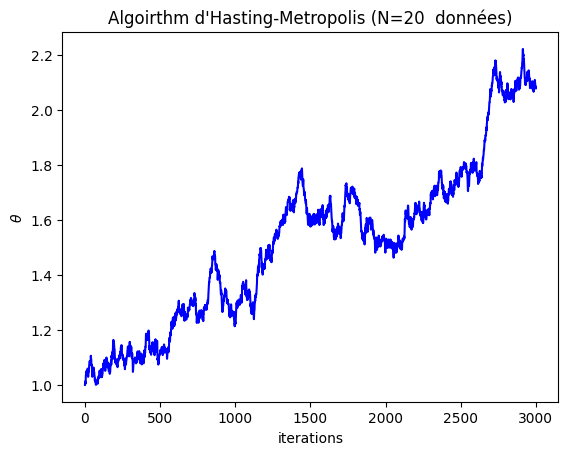

The mean is 1.739.


In [3]:
plt.plot(
    np.linspace(1, nPas, nPas), D0, color="blue", label="prior $\mathcal{U}(0,100)$"
)
plt.title("Algoirthm d'Hasting-Metropolis (N=%i  données)" % N)
plt.xlabel("iterations")
plt.ylabel(r"$\theta$")
plt.show()

Lambda_HMunif = np.mean(D0[-1499:])
print("The mean is {:.3f}.".format(Lambda_HMunif))

4. Comparez le résultat obtenu avec ce que l'on obtient en utilisant la Méthode des moments sur le même set de donnée.  
**Solution:**  



In [4]:
# lambda de distribution de Poisson est son moyen
Lambda_poiss = np.mean(d)
print("The mean is {:.3f}.".format(Lambda_poiss))

The mean is 2.050.


On remarque que les deux valeurs peuvent être assez proches et donner une bonne approximation du lambda de la loi de Poisson qui a servi à générer les données (lambda = 2)
cependant, il n'y a pas assez de données et les résutats peuvent varier de manière significatives d'un tirage à l'autre.


5. Introduisez à présent un prior de type gaussien centré en $2$ et d'écart type 0,1. Calculez ensuite le vecteur ${D}$ correspondant et superposez sur un graph ${D}$ et ${D_{0}}$, qu'observez-vous ?    
**Solution:**  


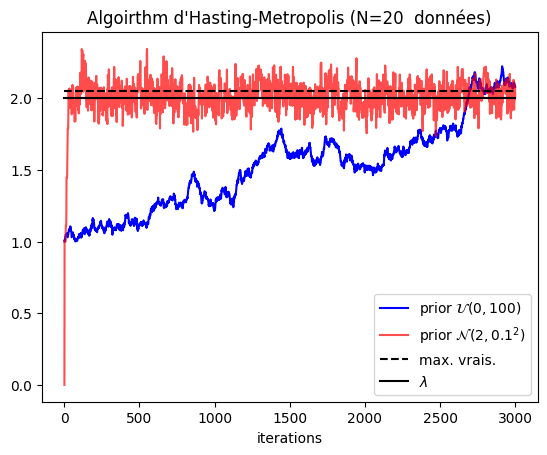

In [5]:
plt.clf()

# on répète l'algorithme précédent en changeant le prior
theta0 = 1
lv = np.sum(np.log(poisson.pmf(d, mu=theta0)))
# log du prior de type gaussien centré en 2 en écart-type 0.1
ec = 0.1  # écart-type
lp = np.log(norm.pdf(theta0, 2, ec))
Q0 = lv + lp

nPas = 3000
D = [0] * nPas

for i in range(1, nPas):
    D[i] = theta0  # enregistrer theta au pas i
    # génération d'un theta candidat selon une loi instrumentale q
    thetai = np.random.normal(theta0, ec)
    # poterior pour le theta candidat
    lvi = np.sum(np.log(poisson.pmf(d, mu=thetai)))
    lpi = np.log(norm.pdf(thetai, 2, ec))
    Q1 = lvi + lpi
    r = np.exp(Q1 - Q0)  # taux d'acceptation
    u = np.random.rand(1, 1)
    if r > u:
        theta0 = thetai
        Q0 = Q1

# comparer le prior uniforme et le prior centré en 2
plt.plot(
    np.linspace(1, nPas, nPas), D0, color="blue", label="prior $\mathcal{U}(0,100)$"
)
plt.title("Algoirthm d'Hasting-Metropolis (N=%i  données)" % N)
plt.xlabel("iterations")

plt.plot(
    np.linspace(1, nPas, nPas), D, "r", label="prior $\mathcal{N}(2,0.1^2)$", alpha=0.7
)
plt.plot([0, nPas], [Lambda_poiss, Lambda_poiss], "--k", label="max. vrais.")
plt.plot([0, nPas], [2, 2], "k", label=r"$\lambda$")
plt.legend()
plt.show()

On remarque que le prior pris selon la loi normale converge plus vite l'utilisation d'un prior correct (p. ex. ici centré en 2) accélère donc la convergence quand il y a peu de données.


6. Changez $N$, augmentez le à une valeur supérieur (par exemple $100$) et refaites cette comparaison (prior uniforme vs prior centré en $2$); augmentez encore $N$ à $200$, que remarquez-vous?  
**Solution:**  


/tmp/ipykernel_243/3239448424.py:21: RuntimeWarning: divide by zero encountered in log
  lpi = np.log(uniform.pdf(thetai, 1, 100))


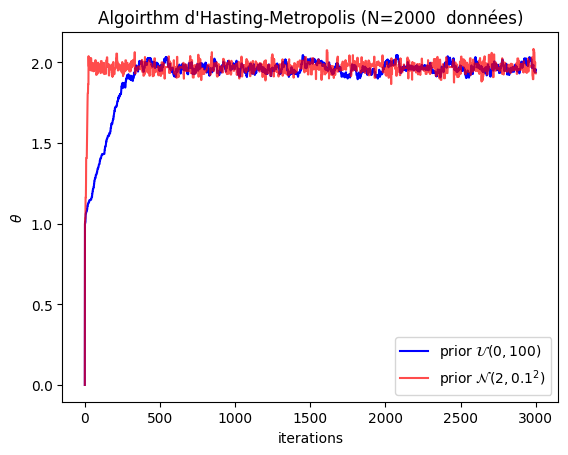

Lambda HM uniform:	 1.965
Lambda HM normal:	 1.971
Lambda Poisson:		 1.964


In [6]:
N = 2000
d = poisson.rvs(mu=Lambda, size=N)

# prior selon loi uniforme
nPas = 3000  # nombre de saut autorisé (d'itération)
theta0 = 1  # theta initial
# log-vraisemblance de theta0
lv = np.sum(np.log(poisson.pmf(d, mu=theta0)))
# log du prior pris selon une loi uniforme U(1,100)
lp = np.log(uniform.pdf(theta0, 1, 100))
Q0 = lv + lp  # posterior pour le theta initial
ec = 0.01  # écart-type
D0 = [0] * nPas

for i in range(1, nPas):
    D0[i] = theta0  # enregistrer theta au pas i
    # génération d'un theta candidat selon une loi instrumentale q
    thetai = np.random.normal(theta0, ec)
    # poterior pour le theta candidat
    lvi = np.sum(np.log(poisson.pmf(d, mu=thetai)))
    lpi = np.log(uniform.pdf(thetai, 1, 100))
    Q1 = lvi + lpi
    r = np.exp(Q1 - Q0)  # taux d'acceptation
    u = np.random.rand(1, 1)
    if r > u:
        theta0 = thetai
        Q0 = Q1

# prior selon loi normale
theta0 = 1
lv = np.sum(np.log(poisson.pmf(d, mu=theta0)))
# log du prior de type gaussien centré en 2 en écart-type 0.1
ec = 0.1  # écart-type
lp = np.log(norm.pdf(theta0, 2, ec))
Q0 = lv + lp

nPas = 3000
D = [0] * nPas

for i in range(1, nPas):
    D[i] = theta0  # enregistrer theta au pas i
    # génération d'un theta candidat selon une loi instrumentale q
    thetai = np.random.normal(theta0, ec)
    # poterior pour le theta candidat
    lvi = np.sum(np.log(poisson.pmf(d, mu=thetai)))
    lpi = np.log(norm.pdf(thetai, 2, ec))
    Q1 = lvi + lpi
    r = np.exp(Q1 - Q0)  # taux d'acceptation
    u = np.random.rand(1, 1)
    if r > u:
        theta0 = thetai
        Q0 = Q1

# comparer encore une fois le prior uniforme et le prior centré en 2
plt.plot(
    np.linspace(1, nPas, nPas), D0, color="blue", label="prior $\mathcal{U}(0,100)$"
)
plt.title("Algoirthm d'Hasting-Metropolis (N=%i  données)" % N)
plt.xlabel("iterations")
plt.ylabel(r"$\theta$")

plt.plot(
    np.linspace(1, nPas, nPas), D, "r", label="prior $\mathcal{N}(2,0.1^2)$", alpha=0.7
)
plt.legend()
plt.show()

Lambda_HMunif = np.mean(D0[-1499:])
Lambda_poiss = np.mean(d)
Lambda_HMnorm = np.mean(D[-1499:])

print(
    "Lambda HM uniform:\t {:.3f}\nLambda HM normal:\t {:.3f}\nLambda Poisson:\t\t {:.3f}".format(
        Lambda_HMunif, Lambda_HMnorm, Lambda_poiss
    )
)

On remarque que le choix du prior importe peu quand le nombre de données est suffisant le choix du prior a alors moins d'importance que la vraisemblance la valeur de lambda est bien estimée par les deux méthodes.


7.  Introduisez un prior de type gaussien centré en 0,5 et d'écart type 0,1. Que constatez-vous pour $N=20,100,200$? Faîtes la même chose pour un prior complètement erroné (par exemple centré en $5$ et d'écart type $1$), que constatez-vous pour $N=20,100,200$?  
**Solution:**  


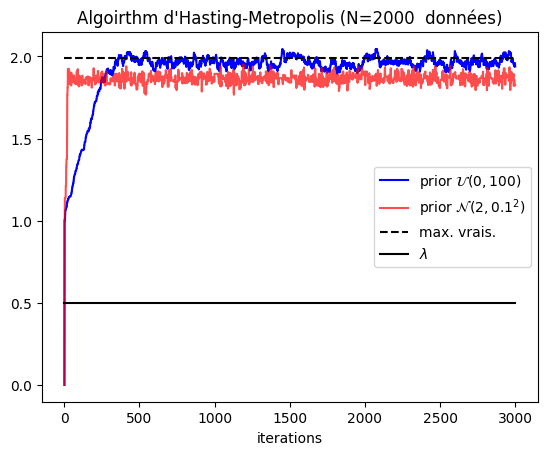

In [7]:
# prior selon loi normale
N = 2000
d = poisson.rvs(mu=Lambda, size=N)
theta0 = 1
lv = np.sum(np.log(poisson.pmf(d, mu=theta0)))
# log du prior de type gaussien centré en 2 en écart-type 0.1
ec = 0.1  # écart-type
centre_gauss = 0.5  # centre de gaussien
lp = np.log(norm.pdf(theta0, centre_gauss, ec))
Q0 = lv + lp

nPas = 3000
D = [0] * nPas

for i in range(1, nPas):
    D[i] = theta0  # enregistrer theta au pas i
    # génération d'un theta candidat selon une loi instrumentale q
    thetai = np.random.normal(theta0, ec)
    # poterior pour le theta candidat
    lvi = np.sum(np.log(poisson.pmf(d, mu=thetai)))
    lpi = np.log(norm.pdf(thetai, centre_gauss, ec))
    Q1 = lvi + lpi
    r = np.exp(Q1 - Q0)  # taux d'acceptation
    u = np.random.rand(1, 1)
    if r > u:
        theta0 = thetai
        Q0 = Q1

Lambda_poiss = np.mean(d)

plt.plot(
    np.linspace(1, nPas, nPas), D0, color="blue", label="prior $\mathcal{U}(0,100)$"
)
plt.title("Algoirthm d'Hasting-Metropolis (N=%i  données)" % N)
plt.xlabel("iterations")

plt.plot(
    np.linspace(1, nPas, nPas), D, "r", label="prior $\mathcal{N}(2,0.1^2)$", alpha=0.7
)
plt.plot([0, nPas], [Lambda_poiss, Lambda_poiss], "--k", label="max. vrais.")
plt.plot([0, nPas], [centre_gauss, centre_gauss], "k", label=r"$\lambda$")
plt.legend()
plt.show()

En prenant un prior erroné (p. ex. centré en 0.5), l'algorithme ne converge pas vers la bonne valeur si le nombre de données est insuffisant en prenant un prior très éronné (p. ex. centré en 5), des problèmes de convergence apparaissent.